In [3]:
from pathlib import Path
from anndata import read_h5ad
import sys
import scanpy
import os
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.stats import nbinom, pearsonr

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
# stimage custom 
file = Path("../stimage").resolve() # path to src code
parent = file.parent
sys.path.append(str(parent))

from tqdm import tqdm

from stimage._utils import gene_plot, Read10X, ReadOldST, tiling
from stimage._model import CNN_NB_multiple_genes, negative_binomial_layer, negative_binomial_loss
from stimage._data_generator import DataGenerator

import pickle

2024-09-06 11:51:10.118438: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-06 11:51:11.667446: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from scipy import stats

def plot_correlation(df, attr_1, attr_2):
    r = stats.pearsonr(df[attr_1], 
                       df[attr_2])[0] **2

    g = sns.lmplot(data=df,
        x=attr_1, y=attr_2,
        height=5, legend=True
    )
    # g.set(ylim=(0, 360), xlim=(0,360))

    g.set_axis_labels(attr_1, attr_2)
    plt.annotate(r'$R^2:{0:.2f}$'.format(r),
                (max(df[attr_1])*0.9, max(df[attr_2])*0.9))
    return g


def calculate_correlation(attr_1, attr_2):
    r = stats.pearsonr(attr_1, 
                       attr_2)[0]
    return r

def calculate_correlation_2(attr_1, attr_2):
    r = stats.spearmanr(attr_1, 
                       attr_2)[0]
    return r

In [ ]:
DATA_PATH = Path("/clusterdata/uqxtan9/Xiao/STimage_100run/dataset_breast_cancer_9visium")

OUT_PATH = Path("/clusterdata/uqxtan9/Xiao/STimage/development/stimage_100run/results_1")

OUT_PATH.mkdir(parents=True, exist_ok=True)

In [5]:
OUT_PATH = Path("/scratch/project_mnt/S0010/Xiao/Q1851/Xiao/Wiener_backup/STimage_exp/stimage_100run/results_1")

In [4]:
adata_all = read_h5ad(DATA_PATH / "all_adata.h5ad")

In [5]:
# update metadata for annadata such that it maps to the correct location
adata_all.obs["tile_path"] = adata_all.obs.tile_path.map(
    lambda x: x.replace("/clusterdata/uqxtan9/Xiao/breast_cancer_9visium",
                        "/scratch/imb/Xiao/STimage_100run/dataset_breast_cancer_9visium"))

In [6]:
# remove FFPE and 1160920F --- the test set
adata_all_train_valid = adata_all[adata_all.obs["library_id"].isin(
    adata_all.obs.library_id.cat.remove_categories(["FFPE", "1160920F"]).unique())]

In [7]:
df_gene_ls = pd.read_csv("/scratch/imb/Xiao/STimage/development/stimage_100run/Intersection_marker_genes.csv", sep=",")

gene_list_select = df_gene_ls["gene_name"].values.tolist()

gene_list = adata_all.var_names.intersection(gene_list_select)

In [8]:
n_genes = len(gene_list)

training_index = adata_all_train_valid.obs.sample(frac=0.7, random_state=1).index
training_dataset = adata_all_train_valid[training_index,].copy()

valid_index = adata_all_train_valid.obs.index.isin(training_index)
valid_dataset = adata_all_train_valid[~valid_index,].copy()

test_index = adata_all.obs.library_id == "FFPE"
test_dataset_1 = adata_all[test_index,].copy()

test_index = adata_all.obs.library_id == "1160920F"
test_dataset_2 = adata_all[test_index,].copy()

In [9]:
train_gen = tf.data.Dataset.from_generator(
            lambda: DataGenerator(adata=training_dataset, 
                          genes=gene_list, aug=False),
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
train_gen_ = train_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
valid_gen = tf.data.Dataset.from_generator(
            lambda: DataGenerator(adata=valid_dataset, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
valid_gen_ = valid_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
test_gen_1 = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=test_dataset_1, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
test_gen__1 = test_gen_1.batch(1)
test_gen_2 = tf.data.Dataset.from_generator(
            lambda: DataGenerator(adata=test_dataset_2, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
test_gen__2 = test_gen_2.batch(1)

In [10]:
def get_samples_stats_geneid(np_preds, list_genes, k=1):
    """
    """
    # mean and var functions of k...
    nb_mean = lambda n, p, k: n*(1-p*k)/(p*k)
    nb_var = lambda n, p, k: n*(1-p*k)/(p*p*k*k)
    
    res = []
    for gene_idx, gene_name in enumerate(list_genes):
        
        # predicted NB params 
        n, p = np_preds[gene_idx][:,0], np_preds[gene_idx][:,1]
        # mean (with p corrected by k factor)
        mu = nb_mean(n, p, k)
        # var (with p corrected by k factor)
        var = nb_var(n, p, k)
        
        res.append(np.stack([n, p, mu, var], axis=1))
        
    return np.stack(res, axis=2)

In [11]:
# ensemble_results1 = []
# ensemble_results2 = []

# for e_id in tqdm(range(50)):
#     e_id # += 1
#     print(f"Ensemble id {e_id}")
#     # load model
#     model = None
#     file_model = str(OUT_PATH / f'model_{e_id}.h5')
#     model = load_model(file_model, 
#                        custom_objects={
#                            'negative_binomial_loss': negative_binomial_loss,
#                        }
#                       )
#     print("loaded")
#     # get predictions 
#     pred_test_1 = model.predict(test_gen__1)
#     print("got preds1")
#     pred_test_2 = model.predict(test_gen__2)
#     print("got preds2")
#     # append results 
#     ensemble_results1.append(get_samples_stats_geneid(pred_test_1, gene_list))
#     ensemble_results2.append(get_samples_stats_geneid(pred_test_2, gene_list))
#     print("appended results")
    
# ensemble_results1 = np.stack(ensemble_results1, axis=3)
# ensemble_results2 = np.stack(ensemble_results2, axis=3)

In [12]:
# # save out results
# with open(str(OUT_PATH / 'ensemble_results_1-all.pkl'), 'wb') as file:
#     pickle.dump(ensemble_results1, file)
# with open(str(OUT_PATH / 'ensemble_results_2-all.pkl'), 'wb') as file:
#     pickle.dump(ensemble_results2, file)

In [13]:
adata = adata_all[adata_all.obs.library_id == "1160920F"][:,gene_list].copy()

In [14]:
for e_id in tqdm(range(49,50)):
    df = pd.DataFrame()
    with open(OUT_PATH / f"ensemble_results_2_{e_id}.pkl", 'rb') as file:
        test_predictions = pickle.load(file)
    print("Predicting Run {}:".format(e_id))
    y_preds_mean = []
    y_preds_var = []
    for i in range(len(gene_list)):
        n = test_predictions[i][:, 0]
        p = test_predictions[i][:, 1]
#       y_pred = nbinom.mean(n, p)
        y_pred_mean, y_pred_var = nbinom.stats(n, p, moments='mv')
        y_preds_mean.append(y_pred_mean)
        y_preds_var.append(y_pred_var)
    adata_ = adata.copy()
    adata_.obsm["predicted_gene_mean"] = np.array(y_preds_mean).transpose()
    adata_.obsm["predicted_gene_var"] = np.array(y_preds_var).transpose()
    adata_.X = adata_.obsm["predicted_gene_mean"]

    adata_.to_df().to_csv(OUT_PATH / "prediction_df_1160920F_{}.csv".format(e_id))
    pred_adata = adata_
    test_dataset = adata.copy()

    for gene in pred_adata.var_names:
        cor_val = calculate_correlation(pred_adata.to_df().loc[:,gene], test_dataset.to_df().loc[:,gene])
        df = df.append(pd.Series([gene, cor_val, "1160920F",e_id], index=["Gene", "Pearson correlation", "Slide", "Run"]),
                  ignore_index=True)
    df.to_csv(OUT_PATH / "corr_df_1160920F_{}.csv".format(e_id))


  0%|          | 0/1 [00:00<?, ?it/s]

Predicting Run 49:


100%|██████████| 1/1 [00:33<00:00, 33.15s/it]


In [11]:
# BASE_PATH = Path("/clusterdata/uqxtan9/Xiao/Q2051/STimage_project/STimage_dataset/RAW/10x_Xenium_breast_cancer/Visium")
adata = read_h5ad("/clusterdata/uqxtan9/Xiao/Q2051/STimage_project/STimage_dataset/RAW/10x_Xenium_breast_cancer/Visium/all_adata.h5ad")

In [ ]:
for e_id in tqdm(range(0,50)):
    df = pd.DataFrame()
    with open(OUT_PATH / f"ensemble_results_3_{e_id}.pkl", 'rb') as file:
        test_predictions = pickle.load(file)
    print("Predicting Run {}:".format(e_id))
    y_preds_mean = []
    y_preds_var = []
    for i in range(len(gene_list)):
        n = test_predictions[i][:, 0]
        p = test_predictions[i][:, 1]
#       y_pred = nbinom.mean(n, p)
        y_pred_mean, y_pred_var = nbinom.stats(n, p, moments='mv')
        y_preds_mean.append(y_pred_mean)
        y_preds_var.append(y_pred_var)
    pred_adata = adata.copy()
    pred_adata.obsm["predicted_gene_mean"] = np.array(y_preds_mean).transpose()
    pred_adata.obsm["predicted_gene_var"] = np.array(y_preds_var).transpose()
#     adata_.X = adata_.obsm["predicted_gene_mean"]

#     adata_.obsm["predicted_gene_var"].to_csv(OUT_PATH / "prediction_df_CFFPE_{}.csv".format(e_id))

    test_dataset = adata.copy()

    for i, gene in enumerate(gene_list):
        try:
            cor_val = calculate_correlation(pred_adata.obsm["predicted_gene_mean"][:,i], test_dataset.to_df().loc[:,gene])
            df = df.append(pd.Series([gene, cor_val, "CFFPE",e_id], index=["Gene", "Pearson correlation", "Slide", "Run"]),
                      ignore_index=True)
        except:
            continue
    df.to_csv(OUT_PATH / "corr_df_CFFPE_{}.csv".format(e_id))


  0%|          | 0/50 [00:00<?, ?it/s]

Predicting Run 0:



  2%|▏         | 1/50 [02:11<1:47:20, 131.44s/it]

Predicting Run 1:



  4%|▍         | 2/50 [04:22<1:45:00, 131.26s/it]

Predicting Run 2:



  6%|▌         | 3/50 [06:34<1:42:56, 131.41s/it]

Predicting Run 3:



  8%|▊         | 4/50 [08:43<1:40:13, 130.72s/it]

Predicting Run 4:


In [14]:
# for e_id in tqdm(range(45,50)):
#     df = pd.DataFrame()
#     with open(OUT_PATH / f"ensemble_results_1_{e_id}.pkl", 'rb') as file:
#         test_predictions = pickle.load(file)
#     print("Predicting Run {}:".format(e_id))
#     y_preds_mean = []
#     y_preds_var = []
#     for i in range(len(gene_list)):
#         n = test_predictions[i][:, 0]
#         p = test_predictions[i][:, 1]
# #       y_pred = nbinom.mean(n, p)
#         y_pred_mean, y_pred_var = nbinom.stats(n, p, moments='mv')
#         y_preds_mean.append(y_pred_mean)
#         y_preds_var.append(y_pred_var)
#     adata_ = adata.copy()
#     adata_.obsm["predicted_gene_mean"] = np.array(y_preds_mean).transpose()
#     adata_.obsm["predicted_gene_var"] = np.array(y_preds_var).transpose()
#     adata_.X = adata_.obsm["predicted_gene_mean"]

#     adata_.to_df().to_csv(OUT_PATH / "prediction_df_FFPE_{}.csv".format(e_id))
#     pred_adata = adata_
#     test_dataset = adata.copy()

#     for gene in pred_adata.var_names:
#         cor_val = calculate_correlation(pred_adata.to_df().loc[:,gene], test_dataset.to_df().loc[:,gene])
#         df = df.append(pd.Series([gene, cor_val, "FFPE",e_id], index=["Gene", "Pearson correlation", "Slide", "Run"]),
#                   ignore_index=True)
#     df.to_csv(OUT_PATH / "corr_df_FFPE_{}.csv".format(e_id))


  0%|          | 0/5 [00:00<?, ?it/s]

Predicting Run 45:



 20%|██        | 1/5 [00:24<01:36, 24.18s/it]

Predicting Run 46:



 40%|████      | 2/5 [00:48<01:12, 24.24s/it]

Predicting Run 47:



 60%|██████    | 3/5 [01:12<00:48, 24.28s/it]

Predicting Run 48:



 80%|████████  | 4/5 [01:37<00:24, 24.37s/it]

Predicting Run 49:


100%|██████████| 5/5 [01:58<00:00, 23.79s/it]


In [15]:
predict_df_list = ["/clusterdata/uqxtan9/Xiao/STimage/development/stimage_100run/results_1/prediction_df_FFPE_{}.csv".format(i) for i in range(50)]

In [17]:
df_ens = pd.DataFrame()
for i in range(5):
    df_list_ens = predict_df_list[i:i+10]
    ens_df = sum([pd.read_csv(j,index_col=0) for j in df_list_ens]) / 10
    ens_df.to_csv("/clusterdata/uqxtan9/Xiao/STimage/development/stimage_100run/results_1/prediction_df_FFPE_ens_{}.csv".format(i))
    pred_adata = adata[:,gene_list].copy()
    pred_adata.X = ens_df
    test_dataset = adata[:,gene_list].copy()

    for gene in pred_adata.var_names:
        cor_val = calculate_correlation(pred_adata.to_df().loc[:,gene], test_dataset.to_df().loc[:,gene])
        df_ens = df_ens.append(pd.Series([gene, cor_val, "FFPE",i], index=["Gene", "Pearson correlation", "Slide", "Run"]),
                  ignore_index=True)

In [ ]:
df_ens["ens_group"] = pd.Categorical(df_ens["Run"].astype(int) +1)

In [ ]:
df_ens

In [18]:
df_ens.to_csv("./matrix_FFPE_120run_ens.csv")

In [6]:
df_ens = pd.read_csv("/scratch/project_mnt/S0010/Xiao/Q1851/Xiao/Working_project/STimage/development/matrix_FFPE_120run_ens.csv", index_col=0)

In [7]:
df = pd.DataFrame()
for e_id in tqdm(range(50)):
    ens_group = e_id // 10
    df_ = pd.read_csv(OUT_PATH / "corr_df_FFPE_{}.csv".format(e_id),index_col=0)
    df_["ens_group"] = ens_group + 1
    df = pd.concat([df, df_], ignore_index=True)
                         

100%|██████████| 50/50 [00:00<00:00, 101.31it/s]


In [8]:
df

,Gene,Pearson correlation,Slide,Run,ens_group
0,ISG15,-0.068980,FFPE,0.0,1
1,TNFRSF18,-0.022639,FFPE,0.0,1
2,TNFRSF4,0.040079,FFPE,0.0,1
3,CALML6,-0.020636,FFPE,0.0,1
4,HES5,0.002152,FFPE,0.0,1
...,...,...,...,...,...
76095,IRAK1,-0.120267,FFPE,49.0,5
76096,FLNA,0.039343,FFPE,49.0,5
76097,DNASE1L1,0.016781,FFPE,49.0,5
76098,G6PD,-0.148963,FFPE,49.0,5


In [9]:
top_10gene_ens = df_ens.groupby("Gene")["Pearson correlation"].mean().sort_values(ascending=False)[0:100].index

In [10]:
df_top_10gene_ens = df_ens[df_ens["Gene"].isin(top_10gene_ens)]

In [17]:
df_top_10gene_ens

,Gene,Pearson correlation,Slide,Run,ens_group
20,C1QA,0.311310,FFPE,0.0,1
21,C1QB,0.246691,FFPE,0.0,1
34,CSF3R,0.223496,FFPE,0.0,1
63,CD53,0.249009,FFPE,0.0,1
76,S100A10,0.348590,FFPE,0.0,1
...,...,...,...,...,...
7530,RAC2,0.236464,FFPE,4.0,5
7557,CYBB,0.354487,FFPE,4.0,5
7592,IL13RA1,0.284365,FFPE,4.0,5
7598,GPC4,0.291607,FFPE,4.0,5


In [13]:
(df.groupby("Gene")["Pearson correlation"].mean() > 0).sum()

1136

In [14]:
top_10gene_df = df.groupby("Gene")["Pearson correlation"].mean().sort_values(ascending=False)[0:100].index

In [15]:
df_top_10gene_df = df[df["Gene"].isin(top_10gene_df)]

/tmp/ipykernel_181233/2457297258.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=df_top_10gene_ens, x='ens_group', y='Pearson correlation', hue='Slide', ci="sd",


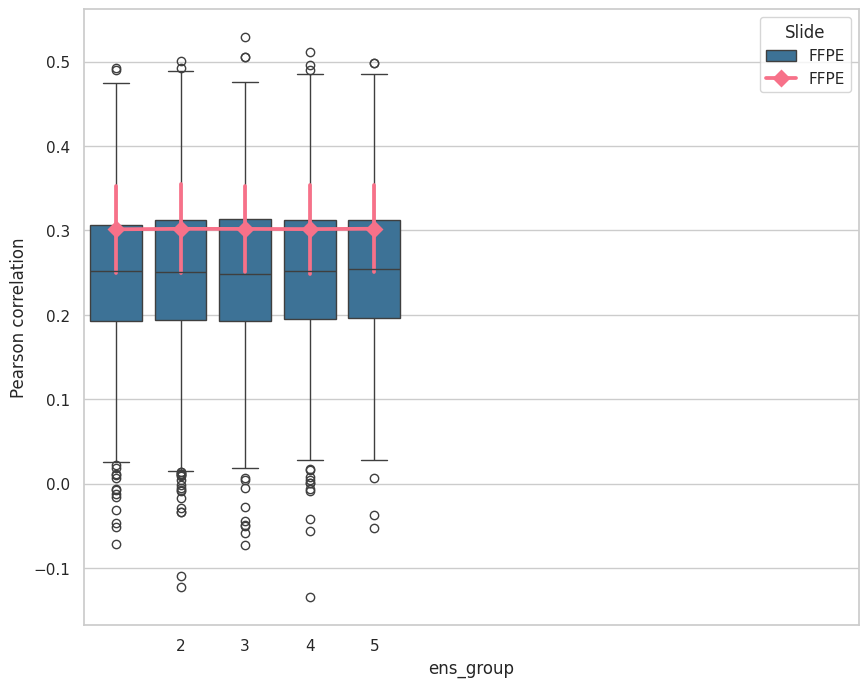

In [22]:
import seaborn as sns
sns.set_theme(style="whitegrid")


fig, ax = plt.subplots(figsize=(10,8))
ax.set_xticks(range(1,13))
sns.boxplot(
    data=df_top_10gene_df,
    x="ens_group", y="Pearson correlation", hue="Slide", saturation=0.6,
    ax=ax, palette="tab10"
)

sns.pointplot(data=df_top_10gene_ens, x='ens_group', y='Pearson correlation', hue='Slide', ci="sd",
            #   dodge=1.8 - 1.8 / 2,
              marker='D', ax=ax, palette="husl")

# sns.lineplot(data=df_ens, x="ens_group", y="Pearson correlation", hue="Slide",
#              marker=True, size=10, ax=ax) 
plt.savefig("./50run_ensemble_boxplot_100_genes.pdf", dpi=300)
plt.show()

In [21]:
top_10gene_ens = df_ens.groupby("Gene")["Pearson correlation"].mean().sort_values(ascending=False)[0:10].index

In [22]:
df_top_10gene_ens = df_ens[df_ens["Gene"].isin(top_10gene_ens)]

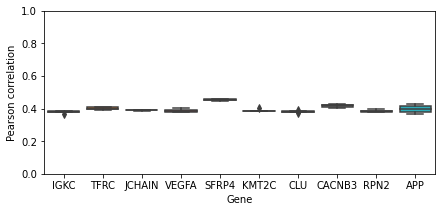

In [30]:
fig, ax = plt.subplots(figsize=(7,3))
sns.boxplot(x="Gene", y="Pearson correlation", data=df_top_10gene_ens, ax=ax)
plt.ylim([0,1])
plt.savefig("./50run_ensemble_boxplot_10_gene.pdf", dpi=300)

In [77]:
df_bar = pd.DataFrame(df_ens.groupby("Gene")["Pearson correlation"].mean().sort_values(ascending=False)).reset_index()

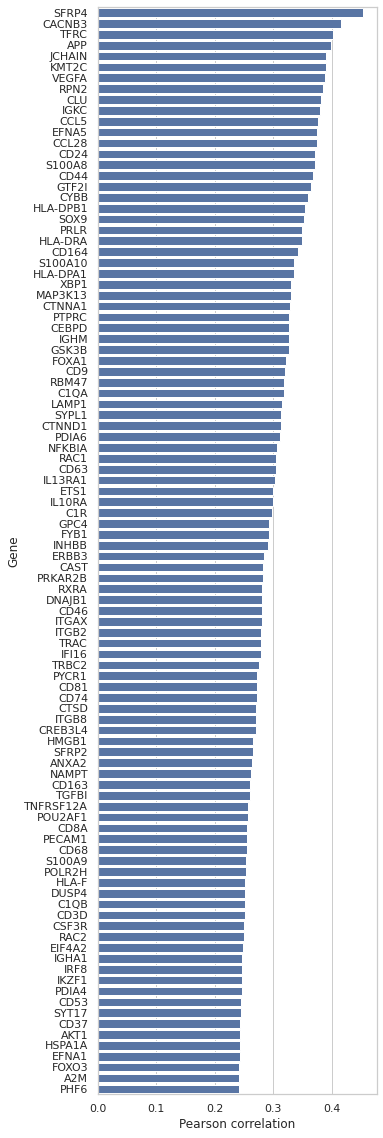

In [82]:
fig, ax = plt.subplots(figsize=(5,20))
sns.barplot(x="Pearson correlation", y="Gene", data=df_bar.iloc[0:100,:],ax=ax,
            label="Total", color="b")
plt.savefig("./50run_ensemble_boxplot_100_gene_bar.pdf", dpi=300)

In [11]:
ensemble_results1 = []
ensemble_results2 = []

for e_id in tqdm(range(50)):
    with open(OUT_PATH / f"ensemble_results_1_{e_id}.pkl", 'rb') as file:
        pred_test_1 = pickle.load(file)
        ensemble_results1.append(get_samples_stats_geneid(pred_test_1, gene_list))
    print("got preds1")
    with open(OUT_PATH / f"ensemble_results_2_{e_id}.pkl", 'rb') as file:
        pred_test_2 = pickle.load(file)
        ensemble_results2.append(get_samples_stats_geneid(pred_test_2, gene_list))
    print("got preds2")
    


  0%|          | 0/50 [00:00<?, ?it/s]

got preds1



  2%|▏         | 1/50 [00:00<00:39,  1.23it/s]

got preds2
got preds1



  4%|▍         | 2/50 [00:01<00:29,  1.65it/s]

got preds2
got preds1



  6%|▌         | 3/50 [00:01<00:25,  1.87it/s]

got preds2
got preds1



  8%|▊         | 4/50 [00:02<00:23,  1.98it/s]

got preds2
got preds1



 10%|█         | 5/50 [00:02<00:21,  2.06it/s]

got preds2
got preds1



 12%|█▏        | 6/50 [00:03<00:22,  1.97it/s]

got preds2
got preds1



 14%|█▍        | 7/50 [00:03<00:22,  1.87it/s]

got preds2
got preds1



 16%|█▌        | 8/50 [00:04<00:21,  1.92it/s]

got preds2
got preds1



 18%|█▊        | 9/50 [00:04<00:20,  2.00it/s]

got preds2
got preds1



 20%|██        | 10/50 [00:05<00:19,  2.08it/s]

got preds2
got preds1



 22%|██▏       | 11/50 [00:05<00:19,  1.99it/s]

got preds2
got preds1



 24%|██▍       | 12/50 [00:06<00:19,  1.98it/s]

got preds2
got preds1



 26%|██▌       | 13/50 [00:06<00:18,  2.00it/s]

got preds2
got preds1



 28%|██▊       | 14/50 [00:07<00:17,  2.03it/s]

got preds2
got preds1



 30%|███       | 15/50 [00:07<00:16,  2.08it/s]

got preds2
got preds1



 32%|███▏      | 16/50 [00:08<00:16,  2.10it/s]

got preds2
got preds1



 34%|███▍      | 17/50 [00:08<00:15,  2.14it/s]

got preds2
got preds1



 36%|███▌      | 18/50 [00:09<00:14,  2.15it/s]

got preds2
got preds1



 38%|███▊      | 19/50 [00:09<00:14,  2.16it/s]

got preds2
got preds1



 40%|████      | 20/50 [00:09<00:13,  2.16it/s]

got preds2
got preds1



 42%|████▏     | 21/50 [00:10<00:13,  2.16it/s]

got preds2
got preds1



 44%|████▍     | 22/50 [00:10<00:12,  2.18it/s]

got preds2
got preds1



 46%|████▌     | 23/50 [00:11<00:12,  2.10it/s]

got preds2
got preds1



 48%|████▊     | 24/50 [00:11<00:13,  1.96it/s]

got preds2
got preds1



 50%|█████     | 25/50 [00:12<00:12,  1.97it/s]

got preds2
got preds1



 52%|█████▏    | 26/50 [00:12<00:11,  2.02it/s]

got preds2
got preds1



 54%|█████▍    | 27/50 [00:13<00:11,  1.99it/s]

got preds2
got preds1



 56%|█████▌    | 28/50 [00:13<00:10,  2.00it/s]

got preds2
got preds1



 58%|█████▊    | 29/50 [00:14<00:10,  2.09it/s]

got preds2
got preds1



 60%|██████    | 30/50 [00:14<00:09,  2.11it/s]

got preds2



 62%|██████▏   | 31/50 [00:15<00:08,  2.18it/s]

got preds1
got preds2
got preds1



 64%|██████▍   | 32/50 [00:15<00:08,  2.21it/s]

got preds2
got preds1



 66%|██████▌   | 33/50 [00:16<00:07,  2.21it/s]

got preds2
got preds1



 68%|██████▊   | 34/50 [00:16<00:07,  2.21it/s]

got preds2
got preds1



 70%|███████   | 35/50 [00:17<00:07,  2.08it/s]

got preds2
got preds1



 72%|███████▏  | 36/50 [00:17<00:06,  2.11it/s]

got preds2
got preds1



 74%|███████▍  | 37/50 [00:18<00:06,  2.05it/s]

got preds2
got preds1



 76%|███████▌  | 38/50 [00:18<00:05,  2.05it/s]

got preds2
got preds1



 78%|███████▊  | 39/50 [00:19<00:05,  2.08it/s]

got preds2
got preds1



 80%|████████  | 40/50 [00:19<00:04,  2.04it/s]

got preds2
got preds1



 82%|████████▏ | 41/50 [00:20<00:04,  2.03it/s]

got preds2
got preds1



 84%|████████▍ | 42/50 [00:20<00:03,  2.02it/s]

got preds2
got preds1



 86%|████████▌ | 43/50 [00:21<00:03,  2.08it/s]

got preds2
got preds1



 88%|████████▊ | 44/50 [00:21<00:02,  2.01it/s]

got preds2
got preds1



 90%|█████████ | 45/50 [00:22<00:02,  2.06it/s]

got preds2
got preds1



 92%|█████████▏| 46/50 [00:22<00:01,  2.10it/s]

got preds2
got preds1



 94%|█████████▍| 47/50 [00:22<00:01,  2.16it/s]

got preds2
got preds1



 96%|█████████▌| 48/50 [00:23<00:00,  2.20it/s]

got preds2
got preds1



 98%|█████████▊| 49/50 [00:23<00:00,  2.11it/s]

got preds2
got preds1


100%|██████████| 50/50 [00:24<00:00,  2.05it/s]

got preds2


In [1]:
# ensemble_results1 = np.stack(ensemble_results1, axis=3)
# ensemble_results2 = np.stack(ensemble_results2, axis=3)

In [ ]:
ensemble_results2.shape

In [32]:
# save out results
with open(str(OUT_PATH / 'ensemble_results_1-rev2.pkl'), 'wb') as file:
    pickle.dump(ensemble_results1, file)
with open(str(OUT_PATH / 'ensemble_results_2-rev2.pkl'), 'wb') as file:
    pickle.dump(ensemble_results2, file)

In [ ]:
df_target_1 = test_dataset_1.to_df().loc[:, gene_list]
df_target_2 = test_dataset_2.to_df().loc[:, gene_list]

In [ ]:
def get_uncertainty_components(ens_res):
    """
    """
    # get E[E[X|f]], E[V[X|f]] 
    mean = ens_res[:,-2:,:,:].mean(axis=-1)
    # get V[E[X|f]], V[V[X|f]] 
    var = ens_res[:,-2:,:,:].var(axis=-1)
    # stack E(mean), V(mean), E(var), total
    res = np.stack([mean[:,0,:], var[:,0,:], mean[:,1,:], var[:,0,:]+mean[:,1,:]], axis=1)
    
    return res

In [ ]:
np_total_var1 = get_uncertainty_components(ensemble_results1)
np_total_var2 = get_uncertainty_components(ensemble_results2)

In [ ]:
# append targets to predictions
np_target1 = df_target_1.values.reshape(len(df_target_1), 1, len(df_target_1.columns))
np_total_var1 = np.append(np_total_var1, np_target1, axis=1)

# np_target2 = df_target_2.values.reshape(len(df_target_2), 1, len(df_target_2.columns))
# np_total_var2 = np.append(np_total_var2, np_target2, axis=1)

In [ ]:
dict_res1 = {g: np_total_var1[:,:,i] for i, g in enumerate(gene_list)}
# dict_res2 = {g: np_total_var2[:,:,i] for i, g in enumerate(gene_list)}

In [ ]:
list_dfs1 = []
for g in dict_res1.keys():
    df = pd.DataFrame(dict_res1[g], columns=['estimate', 'epistemic_uncertainty', 'aleatoric_uncertainty', 'total_uncertainty', 'target'])
    df['gene_name'] = g
    df['index'] = df_target_1.index
    list_dfs1.append(df)
df_res1 = pd.concat(list_dfs1, axis=0)

# list_dfs2 = []
# for g in dict_res2.keys():
#     df = pd.DataFrame(dict_res2[g], columns=['mean', 'epistemic', 'aleatoric', 'total', 'actual'])
#     df['gene_name'] = g
#     list_dfs2.append(df)
# df_res2 = pd.concat(list_dfs2, axis=0)

In [ ]:
df_res1

In [ ]:
adata_FFPE = test_dataset_1[:, gene_list].copy()
# adata_FFPE.obsm["n"] = df.pivot_table(index='index', columns='gene_name', values='n')
# adata_FFPE.obsm["p"] = df.pivot_table(index='index', columns='gene_name', values='p')
adata_FFPE.obsm["estimate"] = df_res1.pivot_table(index='index', columns='gene_name', values='estimate')
adata_FFPE.obsm["epistemic_uncertainty"] = df_res1.pivot_table(index='index', columns='gene_name', values='epistemic_uncertainty')
adata_FFPE.obsm["aleatoric_uncertainty"] = df_res1.pivot_table(index='index', columns='gene_name', values='aleatoric_uncertainty')
adata_FFPE.obsm["total_uncertainty"] = df_res1.pivot_table(index='index', columns='gene_name', values='total_uncertainty')
adata_FFPE.obsm["target"] = df_res1.pivot_table(index='index', columns='gene_name', values='target')